# Weighting profiles

In [1]:
import geopandas as gpd
import pandas as pd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_refined_DFDE_1984_2021_EPSG2154_FR.parquet') #ok 
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet') #ok 
nfi = gpd.read_parquet('../data/processed_datasets/simplified_NFI_2003-2021_EPSG2154_FR.parquet') #ok 
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet") #ok 
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2012_2022_FR_EPSG2154.parquet') #ok 
cdi = gpd.read_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet') #ajouter tree-specie
forms = gpd.read_parquet('../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet') #ok


#preprocessing bdiff:
bdiff['class'] = 'Fire'
bdiff = bdiff[ bdiff.forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#autoreload 
from attribution import Attribution
from constants import DCLASS_SCORE

temporal_buffer = 2 

#subset of datasets
ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff, 'cdi':cdi, 'forms':forms}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon', 'cdi':'polygon', 'forms':'point'}

ddataset_profile = {
    'dfde': {
        'spatial': ('offset_gaussian', {'offset': 150, 'decrease': 5000}), #offset srt( min(area) / pi), k sqrt(median(area) / pi)
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'hm': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 100}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'nfi': {
        'spatial': ('offset_gaussian', {'offset': 600, 'decrease': 25}),
        'temporal': ('step', {'start': 0, 'end': 5 * 365})
    },
    'bdiff': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 30})
    },
    'senfseidl': {
        'spatial': ('offset_gaussian', {'offset': 30, 'decrease': 5 * 30}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 1.5 * 365})
    },
    'forms': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 5*10}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'reference': {
        'spatial': ('offset_gaussian', {'offset': 0, 'decrease': 3 * 50}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'cdi': {
        'spatial': ('offset_gaussian', {'offset': 5000, 'decrease': 500}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 365})
    },
}

#visible disturbances
ddisturbance_profile = {
    'fire': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'storm': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1.5 * 365})
    },
    'biotic-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 1000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 365})
    },
    'drought-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 2*365})
    },
    'biotic-mortality': {
        'spatial': ('gaussian', {'mean': 0, 'std': 250}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'anthropogenic': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1 * 365})
    }
}

doa = {'dfde': 1.0, 'hm': 1.0, 'nfi': 1.0, 'senfseidl': 1., 'bdiff': 1.0, 'cdi':1.0, 'forms':1.0}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None, 'cdi':100, 'forms':100}

attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

dataset dfde is of spatial entity type
-> 95% of the areas are below : 4391.95 km2, median : 71.66 km2
dataset bdiff is of spatial entity type
-> 95% of the areas are below : 127.49 km2, median : 27.37 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 174.72 km2, median : 25.00 km2
senfseidl  -  Storm,Biotic
senfseidl  -  Fire
senfseidl  -  Other
dfde  -  Biotic
dfde  -  Storm
dfde  -  Fire
dfde  -  Drought
dfde  -  Other
nfi  -  Mortality
nfi  -  Storm
nfi  -  Fire
nfi  -  Other
nfi  -  Anthropogenic
hm  -  Biotic-mortality
hm  -  Biotic-dieback
hm  -  Storm
hm  -  Fire
hm  -  Drought-dieback
hm  -  Other
cdi  -  drought
forms  -  clear-cut
bdiff  -  Fire
reference  -  None


In [2]:
dataset = 'nfi'
c = 'Other'

ddataset_profile = attribution.ddataset_profile[dataset]['spatial'] 

attribution.final_weighting_dict[dataset][c]['spatial'] 

<function utils.get_combined_weighting.<locals>.<lambda>(x)>

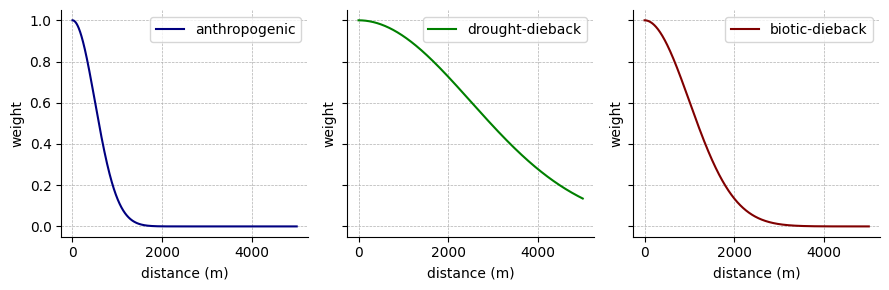

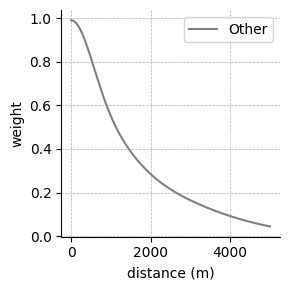

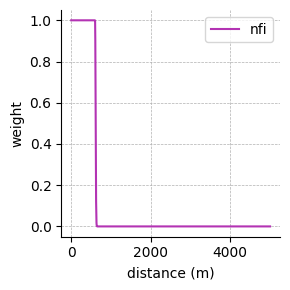

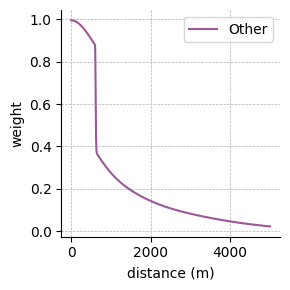

In [15]:
from constants import DCLASS_SCORE
from utils import dfunction
import matplotlib.pyplot as plt
import numpy as np 

x = np.linspace(0, 5000, 1000)

#disturbances profiles 
fig1, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
color = [(0,0,0.5), (0,0.5,0), (0.5,0,0), (0.5,0.5,0.5), (0.7,0.2,0.7), (0.6,0.35,0.6)]
n = len(DCLASS_SCORE[dataset][c])
for i,subclass  in enumerate(DCLASS_SCORE[dataset][c]):
    func_name, args = attribution.ddisturbance_profile[subclass]['spatial']
    y = [dfunction[func_name](xi, **args) for xi in x]
    axes[i].plot(x, y, label=subclass, color=color[i])

for ax in axes:
    ax.set_xlabel('distance (m)')
    ax.set_ylabel('weight')
    ax.legend()
    #remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linestyle='--', lw=0.5)

plt.tight_layout()
plt.show()

#combination 
from utils import combine_functions
disturbance_funcs_scores = [(attribution.ddisturbance_profile[disturbance_class]['spatial'], score) for disturbance_class, score in DCLASS_SCORE[dataset][c].items()]
disturbance_funcs = [lambda x, f=dfunction[fn], p=p: f(x, **p) for (fn, p), _ in disturbance_funcs_scores]
scores = [score for _, score in disturbance_funcs_scores]

combined_disturbance_func = combine_functions(disturbance_funcs, scores)
y = [combined_disturbance_func(xi) for xi in x]
fig2, axes = plt.subplots(1, 1, figsize=(3, 3), sharey=True)
axes.plot(x, y, label=c, color=color[3])
axes.set_xlabel('distance (m)')
axes.set_ylabel('weight')
axes.legend()
#remove top and right spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.grid(linestyle='--', lw=0.5)
plt.tight_layout()
plt.show()

#dataset profile
func_name, args = attribution.ddataset_profile[dataset]['spatial']
y = [dfunction[func_name](xi, **args) for xi in x]
fig3, axes = plt.subplots(1, 1, figsize=(3, 3), sharey=True)
axes.plot(x, y, label=dataset, color=color[4])
axes.set_xlabel('distance (m)')
axes.set_ylabel('weight')
axes.legend()
#remove top and right spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.grid(linestyle='--', lw=0.5)
plt.tight_layout()
plt.show()

#final weighting
fig4, axes = plt.subplots(1, 1, figsize=(3, 3), sharey=True)
y = [attribution.final_weighting_dict[dataset][c]['spatial'](xi) for xi in x]
axes.plot(x, y, label=c, color=color[5])
axes.set_xlabel('distance (m)')
axes.set_ylabel('weight')
axes.legend()
#remove top and right spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.grid(linestyle='--', lw=0.5)
plt.tight_layout()
plt.show()

In [16]:
fig1.savefig(f'../figures/ex_disturbance_profiles_{dataset}_{c}.png', dpi=300)
fig2.savefig(f'../figures/ex_combined_disturbance_profile_{dataset}_{c}.png', dpi=300)
fig3.savefig(f'../figures/ex_dataset_profile_{dataset}_{c}.png', dpi=300)
fig4.savefig(f'../figures/ex_final_weighting_{dataset}_{c}.png', dpi=300)

# Louvain communities

In [1]:
#load datasets
import geopandas as gpd
import pandas as pd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_refined_DFDE_1984_2021_EPSG2154_FR.parquet') #ok 
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet') #ok 
nfi = gpd.read_parquet('../data/processed_datasets/simplified_NFI_2003-2021_EPSG2154_FR.parquet') #ok 
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet") #ok 
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2012_2022_FR_EPSG2154.parquet') #ok 
cdi = gpd.read_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet') #ok
forms = gpd.read_parquet('../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet') #ok
firepolygon = gpd.read_parquet('../data/processed_datasets/simplified_firepolygons_2017_2020_FR_EPSG2154.parquet') #ok

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#preprocessing bdiff:
firepolygon['class'] = 'Fire'
#add end date with offset of 7 days 
firepolygon['end_date'] = pd.to_datetime(firepolygon['start_date']) + pd.to_timedelta(7, unit='d')
bdiff['class'] = 'Fire'
bdiff = bdiff[ bdiff.forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

#autoreload 
from attribution2 import Attribution
from constants import DCLASS_SCORE

temporal_buffer = 2 

#subset of datasets
ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff, 'cdi':cdi, 'forms':forms, 'firepolygons':firepolygon}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon', 'firepolygons': 'polygon', 'cdi':'polygon', 'forms':'point'}

ddataset_profile = {
    'dfde': {
        'spatial': ('offset_gaussian', {'offset': 150, 'decrease': 5000}), #offset srt( min(area) / pi), k sqrt(median(area) / pi)
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'hm': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 100}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'nfi': {
        'spatial': ('offset_gaussian', {'offset': 600, 'decrease': 25}),
        'temporal': ('step', {'start': 0, 'end': 5 * 365})
    },
    'bdiff': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 30})
    },
    'firepolygons': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 50}),
        'temporal': ('offset_gaussian', {'offset': 7, 'decrease': 31})
    },
    'senfseidl': {
        'spatial': ('offset_gaussian', {'offset': 30, 'decrease': 5 * 30}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 1.5 * 365})
    },
    'forms': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 5*10}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'cdi': {
        'spatial': ('offset_gaussian', {'offset': 5000, 'decrease': 500}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 365})
    },
    'reference': {
        'spatial': ('offset_gaussian', {'offset': 0, 'decrease': 3 * 50}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
}

#visible disturbances
ddisturbance_profile = {
    'fire': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'storm': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1.5 * 365})
    },
    'biotic-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 1000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 365})
    },
    'drought-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 2*365})
    },
    'biotic-mortality': {
        'spatial': ('gaussian', {'mean': 0, 'std': 250}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'anthropogenic': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1 * 365})
    }
}

doa = {'dfde': 1.0, 'hm': 1.0, 'nfi': 1.0, 'senfseidl': .75, 'bdiff': 1.0, 'cdi':.75, 'forms':0.75, 'firepolygons':1.0}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None, 'cdi':100, 'forms':100, 'firepolygons':100}

attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

dataset dfde is of spatial entity type
-> 95% of the areas are below : 4391.95 km2, median : 71.66 km2
dataset bdiff is of spatial entity type
-> 95% of the areas are below : 127.49 km2, median : 27.37 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 124.78 km2, median : 24.99 km2


In [2]:
#load communities 
dim = 2
resolution = 100
spatial_threshold = 600
temporal_threshold = 360

from shapely import box
from shapely.geometry import shape 
import numpy as np
bounds_4326 = (4.75,47.10,6.82,48.51)
pol_4326 = box(*bounds_4326)
import rasterio 
from rasterio.warp import transform_geom
pol_2154 = shape(transform_geom('epsg:4326', attribution.dataset.crs, pol_4326))
_dataset = attribution.dataset.clip(pol_2154)
n = _dataset.shape[0] / attribution.dataset.shape[0] * 100
_spatial_entity_dataset = attribution.spatial_entity_dataset.clip(pol_2154)
m = _spatial_entity_dataset.shape[0] / attribution.spatial_entity_dataset.shape[0] * 100
b = "_".join([str(x) for x in bounds_4326])

all_clusters_gdf = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")
c = all_clusters_gdf.shape[0] / (_spatial_entity_dataset.shape[0] + _dataset.shape[0] )
print(c)

0.9983590520369845


In [13]:
all_clusters_gdf_v2 = all_clusters_gdf.rename(columns={'class': 'cause'})
all_clusters_gdf_v2.geometry = all_clusters_gdf_v2.geometry.centroid
subpart = all_clusters_gdf_v2.iloc[4000:4250]

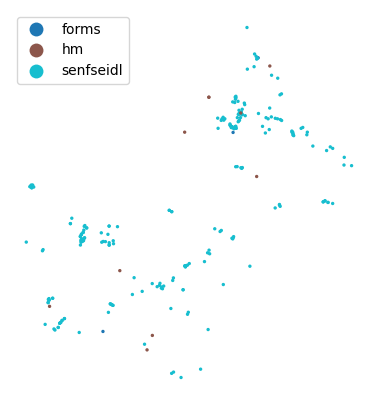

In [74]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

subpart.plot(ax=ax, column='dataset', markersize=2, legend=True)
ax.set_axis_off()
fig.savefig('../figures/example_subgraph.png', dpi=300)

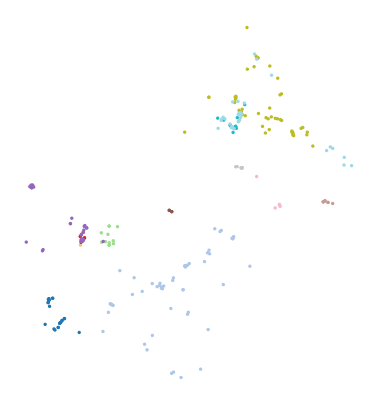

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))


subpart.plot(ax=ax, column='cluster', markersize=2, cmap='tab20')
ax.set_axis_off()
fig.savefig('../figures/example_subgraph_louvain_communities.png', dpi=300)

In [45]:
subpart.cluster.unique()

array([226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238])

<Axes: >

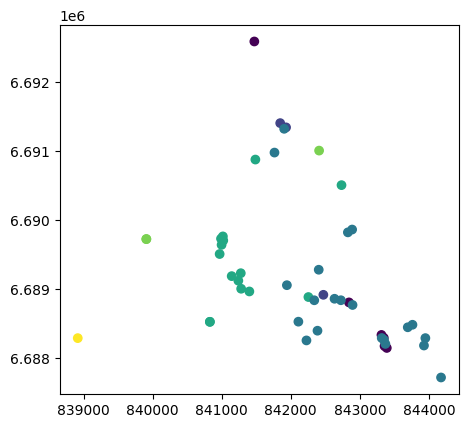

In [39]:
import pandas as pd
subpart.centroid_date = pd.to_datetime(subpart.centroid_date).dt.year
subpart[ subpart.cluster == 236 ].plot(column='centroid_date') #236 #227

In [16]:
from utils import compute_class_similarity_v2, compute_spatial_distance_v2, compute_tree_coherence_v2
weights = {
    'equal' : [0.25, 0.25, 0.25, 0.25],
    'PCA' : [0.23017731, 0.40759976, 0.20566699, 0.15655594],
    'ECO' : [2, 2, 1, 3]
}
method = 'DBSCAN'
filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)
dcustom_similarity_function_v2 = {'spatial_distance': (compute_spatial_distance_v2, {'final_weighting_dict': attribution.final_weighting_dict}), 
                                  'tree_coherence': (compute_tree_coherence_v2, {'filter_cause': filter_class}), 
                                  'class_similarity': (compute_class_similarity_v2, {'dclass_score': DCLASS_SCORE})}

In [58]:
from constants import DCLASS_SCORE
from utils import get_matrices_v2, build_similarity_v2, get_cluster_v2  
weight = weights['equal']
method = 'HDBSCAN'
kwargs = {'min_cluster_size': 2}
data = subpart[ subpart.cluster == 236 ] #227
matrice = get_matrices_v2(data,  dtypes, dcustom_similarity_function_v2, attribution.final_weighting_dict)
similarity = build_similarity_v2(matrice, weight)
gdf, _, labels = get_cluster_v2(data, similarity, attribution.final_weighting_dict, attribution.doa, DCLASS_SCORE, method=method, method_kwargs=kwargs) 


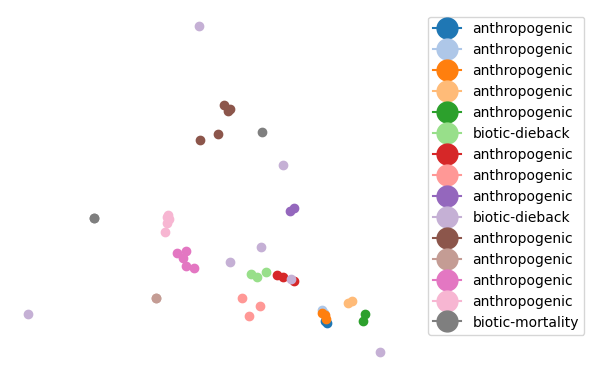

In [93]:
#HDBSCAN
from matplotlib.lines import Line2D

legend = []
labels = []
cm = plt.get_cmap('tab20')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, (name, row) in enumerate(gdf.iterrows()):
    color = cm(i/20)
    subgdf = data.loc[row['Indexes']]
    subgdf.plot(ax=ax, color=color)
    subgdf.geometry.centroid.centroid
    legend.append( Line2D([0], [0], marker='o', color=color, label='Scatter',
                          markerfacecolor=color, markersize=15) )
    labels.append(row['Class'])
    

ax.set_axis_off()
legend = ax.legend(legend, labels, bbox_to_anchor=(1.5, 1))
fig.savefig('../figures/example_subgraph_HDBSCAN.png', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
#

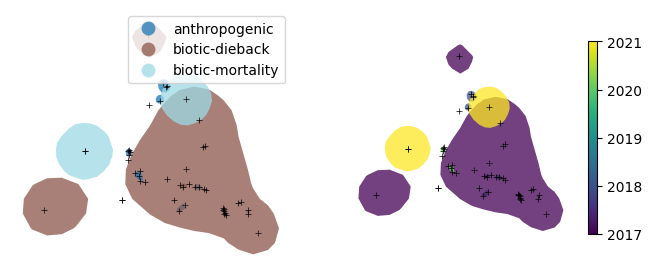

In [91]:
#Spatial and Temporal closed forms estimation of disturbance clusters from reliability profiles
import matplotlib.pyplot as plt
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

#ax1
gdf.plot(column='Class', cmap='tab20', ax=ax1, legend=True, alpha=0.75)
data.plot(ax=ax1, marker='+', color='k', markersize=15, lw=0.5)
#ax2 
gdf['Year'] = pd.to_datetime(gdf.Start_Date).dt.year
gdf.plot(column='Year', ax=ax2, legend=True, alpha=0.75, legend_kwds={'shrink': 0.5})
data.plot(ax=ax2, marker='+', color='k', markersize=15, lw=0.5)

for ax in [ax1, ax2]:
    ax.set_axis_off()

fig.savefig('../figures/example_subgraph_reliability_zone.png', dpi=300)
